# Case 1 - Vungle A/B Testing Analysis

In [309]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import scipy.stats as ss

## Data Loading and Cleaning

CSV files are read into a dataframe each and empty columns are removed.

In [298]:
dfa = pd.read_csv('vungle_testA.csv',engine='python',skipfooter=2,thousands=',',parse_dates=['Date'])
dfb = pd.read_csv('vungle_testB.csv',engine='python',skipfooter=2,thousands=',',parse_dates=['Date'])
# Empty columns from csv are dropped
dfa = dfa.drop(columns=['Unnamed: 6','Unnamed: 7'])
dfb = dfb.drop(columns=['Unnamed: 6','Unnamed: 7'])

Test B sample size is 1/15th that of Test A, so it is scaled by 15x. B is scaled up instead of A being scaled down to keep them as whole numbers.

In [299]:
dfb.iloc[:,1:5] = dfb.iloc[:,1:5].mul(15)

The datasets are combined into a single database and the data types are corrected.

In [300]:
# Combining datasets A and B
pieces = {'A': dfa, 'B': dfb}
df = pd.concat(pieces, names=['Test'])
df = df.reset_index(level=0).reset_index(drop=True)
# Converting the new test column into a category type
df['Test'] = df['Test'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Test          60 non-null     category      
 1   Date          60 non-null     datetime64[ns]
 2   Impressions   60 non-null     int64         
 3   Completes     60 non-null     int64         
 4   Clicks        60 non-null     int64         
 5   Installs      60 non-null     int64         
 6   eRPM          60 non-null     float64       
dtypes: category(1), datetime64[ns](1), float64(1), int64(4)
memory usage: 3.1 KB


## Data Exploration

The occurences at each of the various stages in the funnel are compared.

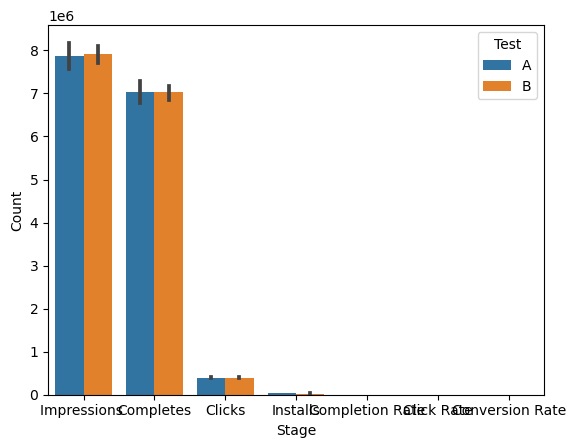

In [307]:
# Create a bar plot showing only the success rates
dataplot = df.melt(['Date','Test','eRPM'],var_name='Stage',value_name='Count')
sns.barplot(data=dataplot,x='Stage',y='Count',hue='Test')
plt.show()

As the impressions are roughly the same, it can be assumed that the fill rate in both cases is the same.

The variances for test B are lower than that of test A, and this makes sense because of the smaller sample size.

Interestingly, the rest of the stages also have similar occurences. The success rates at each stage are calculated and a new dataset is created for these output variables.

In [302]:
# Output variables (success rates) are calculated
df['Completion Rate'] = df['Completes']/df['Impressions ']
df['Click Rate'] = df['Clicks']/df['Completes']
df['Conversion Rate'] = df['Installs']/df['Clicks']
# Create new dataset including only the test (A or B), date, and success rates
df2 = df.drop(df.columns[2:7],axis=1)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Test             60 non-null     category      
 1   Date             60 non-null     datetime64[ns]
 2   Completion Rate  60 non-null     float64       
 3   Click Rate       60 non-null     float64       
 4   Conversion Rate  60 non-null     float64       
dtypes: category(1), datetime64[ns](1), float64(3)
memory usage: 2.2 KB


Success rates for each output variable (labelled as metric) are displayed. Test A and B success rates appear to be similar throughout the funnel.

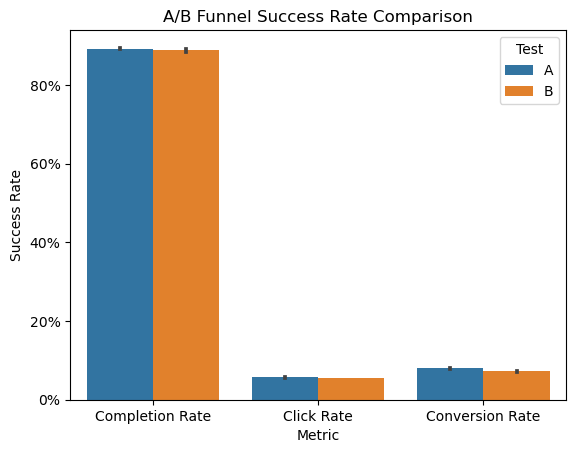

In [303]:
# Create a bar plot showing only success rates
dp = df2.melt(['Date','Test'],var_name='Metric',value_name='Success Rate')
ax = sns.barplot(data=dp,x='Metric',y='Success Rate',hue='Test')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_title('A/B Funnel Success Rate Comparison')
plt.show()

Histograms for success metrics and eRPM show that they are all fairly normal in distribution. The mean values can be used in this case. From observation, Test B appears to be distributed lower than Test A for each metric.

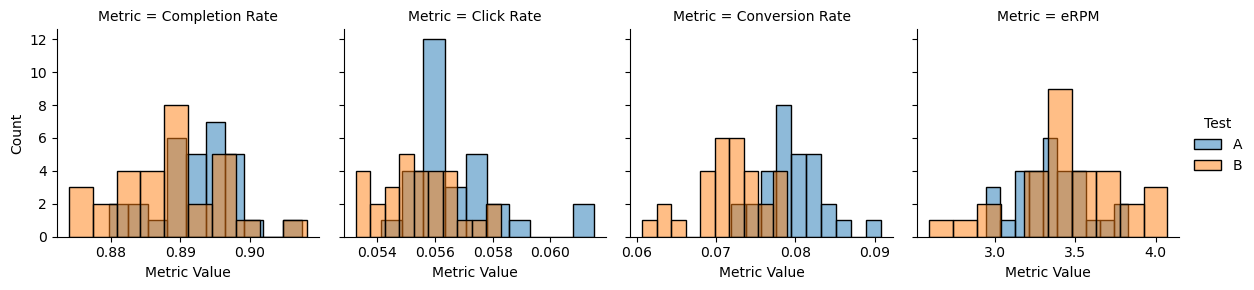

In [317]:
# Create histogram plots for each success rate
df3 = df2.assign(eRPM=df['eRPM'])
dp2 = df3.melt(['Date','Test'],var_name='Metric',value_name='Metric Value')
g = sns.FacetGrid(data=dp2,col='Metric',hue='Test',sharex=False)
g.map(sns.histplot, 'Metric Value',bins=10,alpha=.5)
g.add_legend()
plt.show()

Mean values are displayed and the comparison for eRPM shows a difference of $0.112, which is different from the $0.131 calculation in the case. Each Test B metric has a lower mean than that of Test A, with the exception of eRPM.

In [305]:
df3.groupby('Test').mean()

,Completion Rate,Click Rate,Conversion Rate,eRPM
Test,,,,
A,0.893070,0.056756,0.079511,3.3471
B,0.888289,0.055466,0.071855,3.4590


eRPM for A and B are plotted below showing the quartiles and the mean. From observation, the eRPM for B is distributed higher than for A, with the exception of some outliers.

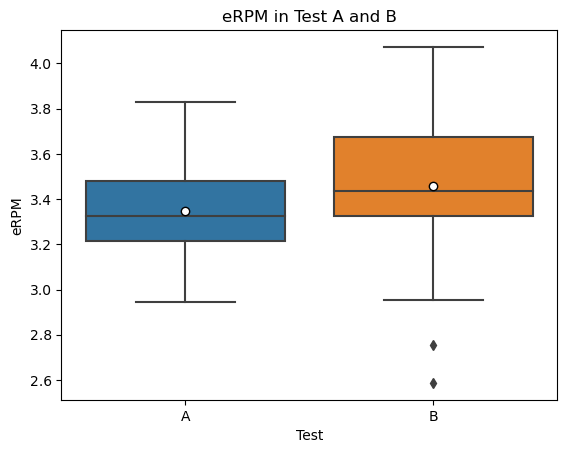

In [308]:
# Create a boxplot with formatting for the mean
ax2 = sns.boxplot(
                data=df,
                y='eRPM',
                x='Test',
                showmeans=True,
                meanprops={"marker":"o",
                    "markerfacecolor":"white", 
                    "markeredgecolor":"black"})
ax2.set_title('eRPM in Test A and B')
plt.show()

Tests A and B are independent samples, and so a t-test can be conducted to check for significance in the difference between their means, with the null hypthoesis being that both tests yield the same eRPM. As the variance for the two tests is different, this is accounted for.

In [311]:
ss.ttest_ind(dfa['eRPM'],dfb['eRPM'],equal_var=False)

Ttest_indResult(statistic=-1.5064382333172264, pvalue=0.13839684895114945)

The t-test outputs a p-value of .138, which is above the 5% measure of significance and the null hypothesis cannot be rejected. It can be concluded from this test that Test B does not deliver any significant improvement to the eRPM.

## Discussion

1. Although the average eRPM in test B is $0.131 higher, the calculation of the average eRPM from the dataset shows a slightly lower value. Furthermore, the t-test gives a p-value higher than 5% which does not allow us to reject the null hypothesis.
------
2. Key assumptions were made:
   - Algorithm B was created with the intent to improve eRPM.
   - The eRPM is calculated as a function of the *fill rate*, *completion rate*, *click rate*, and *completion rate*.
   - Algorithm B does not affect the fill rate.

--------

3. Because of the differences in mean eRPM from the case, it is possible that there are additional factors in the way it is calculated. It is also possible that because algorithm B is a learning algorithm and is newly implemented, it has not been trained properly or is still adjusting to real-life data. It should be noted that while algorithm B does not perform better than A, it also does not perform worse; there is no cost to eRPM in continuing this test.
   
   This A/B test should continue for another month and then re-assessed. Any differences in performance can be compared to this dataset. If there are none, then it would be recommended to re-assess the eRPM formula.